# many_analyses_plots
Author: Noah Stiegler

April 2023

This notebook is for analyzing the results of many inference runs on many checkpoints on many data files

The results used with this script in April 2023 are located on the Tufts Cluster at: /cluster/home/nstieg01/validation_proj/slurm_results

First, import everything we'll need

In [1]:
# Everything uses numpy
import numpy as np

# Import matplotlib for viewing confusion matrices
import matplotlib.pyplot as plt

# Import from sklearn for making a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

All of the datafiles I used are listed in full_data_files.txt. First check if the file is there

In [2]:
%%bash
ls /cluster/home/nstieg01/nutufts_validation_proj/validation_proj/full_data_files.txt

/cluster/home/nstieg01/nutufts_validation_proj/validation_proj/full_data_files.txt


Then get all of the filenames from the file

In [3]:
with open("/cluster/home/nstieg01/nutufts_validation_proj/validation_proj/full_data_files.txt") as f:
    files = [line.rstrip() for line in f]
    
print(files)

['mlrecodata_bnb_nu_0540.root', 'mlrecodata_bnb_nu_0550.root', 'mlrecodata_bnb_nu_0553.root', 'mlrecodata_bnb_nu_0560.root', 'mlrecodata_bnb_nu_0563.root', 'mlrecodata_bnb_nu_0570.root', 'mlrecodata_bnb_nu_0572.root', 'mlrecodata_bnbnue_0460.root', 'mlrecodata_bnbnue_0462.root', 'mlrecodata_bnbnue_0472.root', 'mlrecodata_bnbnue_0475.root', 'mlrecodata_bnbnue_0482.root', 'mlrecodata_bnbnue_0490.root', 'mlrecodata_bnbnue_0492.root']


In [4]:
# Extract Confusion Matrices & Labels from a .npy saved analysis file
# Returns cosmics, non_cosmics, labels
def extract_cms(filepath):
    # Open the saved file & load in data
    with open(filepath, 'rb') as f:
        result = np.load(f, allow_pickle=True)
    
    # Get cosmic, non-cosmic, and label data
    # cosmic and non-cosmic are still arrays of confusion matrices for each event, will want to combine
    non_cosmics = [event["confusion_matrices"]["non_cosmics"] for event in result]
    cosmics = [event["confusion_matrices"]["cosmics"] for event in result]
    labels = result[0]["confusion_matrices"]["labels"] # Labels should be the same for all, so just need labels from one
    
    # Combine confusion matrices from all events, and then from the non-cosmics and cosmics for all events
    all_non_cosmics = sum(non_cosmics)
    all_cosmics = sum(cosmics)
    
    # Return stuff
    return all_cosmics, all_non_cosmics, labels

In [5]:
# Setup
OUTPUT_DIR = "/cluster/home/nstieg01/validation_proj/slurm_results/"

# Loop over all 10 chosen snapshots, filling out this array as we see them
snapshots = [None, None, None, None, None, None, None, None, None, None]
snapshot_nums = range(129999, 760000, 70000)
for i, snapshot_num in enumerate(snapshot_nums):
    # Setup results for each snapshot
    result = {}
    all_cosmics = []
    all_non_cosmics = []
    all_labels = []
    
    # Loop over all files analyzed for each snapshot and extract cosmics & non-cosmics
    for file in files:
        analysis_location = OUTPUT_DIR + "analysis_data_" + str(snapshot_num) + "_" + str(file) + ".npy"
        cosmics, non_cosmics, labels = extract_cms(analysis_location)
        all_cosmics.append(cosmics)
        all_non_cosmics.append(non_cosmics)
        all_labels.append(labels)
    
    # Add together all individual confusion matrices from each file & put in result
    result["cosmics"] = sum(all_cosmics)
    result["non_cosmics"] = sum(all_non_cosmics)
    result["total"] = result["cosmics"] + result["non_cosmics"]
    result["labels"] = all_labels[0]
    
    # Store this snapshot's result
    snapshots[i] = result

In [6]:
labels = snapshots[0]["labels"]
print(labels)

['proton', 'MIPs', 'e$^-$/e$^+$/$\\gamma$', '$\\Delta$-ray', 'Michel', 'ghost']


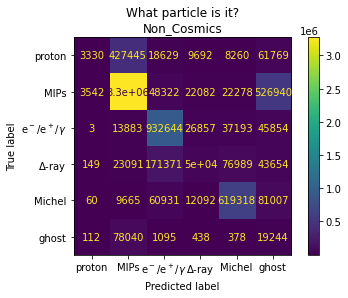

In [25]:
# Plot the total confusion matrix for all events for a snapshot
disp = ConfusionMatrixDisplay(confusion_matrix=snapshots[0]["non_cosmics"], display_labels=snapshots[0]["labels"])
disp.plot()
plt.title("What particle is it?\nNon_Cosmics")
plt.show()

In [19]:
# Return the normalized version a given confusion matrix
# True normalized means that rows add up to 100%
def normalize_true(confusion_matrix):
    normalized = np.zeros(confusion_matrix.shape)
    for i, row in enumerate(confusion_matrix):
        total = np.sum(row)
        for j, col in enumerate(row):
            if total != 0:
                normalized[i, j] = col / total
            else:
                normalized[i, j] = 0
    return normalized

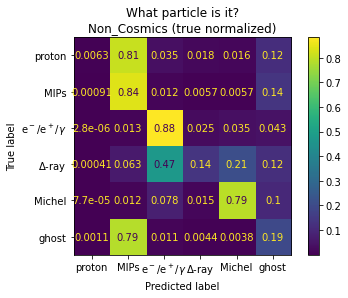

In [26]:
# Plot the total confusion matrix for all events for a snapshot
disp = ConfusionMatrixDisplay(normalize_true(confusion_matrix=snapshots[0]["non_cosmics"]), display_labels=snapshots[0]["labels"])
disp.plot()
plt.title("What particle is it?\nNon_Cosmics (true normalized)")
plt.show()

In [8]:
snapshots[0]["cosmics"]

array([[     6007,    700827,     38376,      2398,      4501,    157072],
       [     6820,   9458744,   1239507,      7801,     16566,   1129647],
       [      512,   1613959,  93514386,     32254,     48033,   2271175],
       [       94,      7528,     73216,      1913,     16638,      8389],
       [       21,     10650,    120952,      4593,    260736,     61848],
       [     1589,   5501632,  11428151,     52064,    191165, 247526548]])

In [9]:
snapshots[0]["cosmics"][0]

array([  6007, 700827,  38376,   2398,   4501, 157072])

In [10]:
# Get stats each snapshot
# Recall has to do with voxels which are really X. It's correctly guessed X / all which are really X
# For cosmics
c_proton_rec = []
c_MIP_rec = []
c_e_rec = []
c_delta_rec = []
c_michel_rec = []
c_ghost_rec = []

# Noncosmics
nc_proton_rec = []
nc_MIP_rec = []
nc_e_rec = []
nc_delta_rec = []
nc_michel_rec = []
nc_ghost_rec = []

# Total
t_proton_rec = []
t_MIP_rec = []
t_e_rec = []
t_delta_rec = []
t_michel_rec = []
t_ghost_rec = []

# Accuracy is correct (diagonals) divided by all voxels
total_acc = []
non_cosmic_acc = []
cosmic_acc = []
for snapshot in snapshots:
    c_proton_rec.append(snapshot["cosmics"][0][0] / sum(snapshot["cosmics"][0]))
    c_MIP_rec.append(snapshot["cosmics"][1][1] / sum(snapshot["cosmics"][1]))
    c_e_rec.append(snapshot["cosmics"][2][2] / sum(snapshot["cosmics"][2]))
    c_delta_rec.append(snapshot["cosmics"][3][3] / sum(snapshot["cosmics"][3]))
    c_michel_rec.append(snapshot["cosmics"][4][4] / sum(snapshot["cosmics"][4]))
    c_ghost_rec.append(snapshot["cosmics"][5][5] / sum(snapshot["cosmics"][5]))
    
    nc_proton_rec.append(snapshot["non_cosmics"][0][0] / sum(snapshot["non_cosmics"][0]))
    nc_MIP_rec.append(snapshot["non_cosmics"][1][1] / sum(snapshot["non_cosmics"][1]))
    nc_e_rec.append(snapshot["non_cosmics"][2][2] / sum(snapshot["non_cosmics"][2]))
    nc_delta_rec.append(snapshot["non_cosmics"][3][3] / sum(snapshot["non_cosmics"][3]))
    nc_michel_rec.append(snapshot["non_cosmics"][4][4] / sum(snapshot["non_cosmics"][4]))
    nc_ghost_rec.append(snapshot["non_cosmics"][5][5] / sum(snapshot["non_cosmics"][5]))
    
    t_proton_rec.append(snapshot["total"][0][0] / sum(snapshot["total"][0]))
    t_MIP_rec.append(snapshot["total"][1][1] / sum(snapshot["total"][1]))
    t_e_rec.append(snapshot["total"][2][2] / sum(snapshot["total"][2]))
    t_delta_rec.append(snapshot["total"][3][3] / sum(snapshot["total"][3]))
    t_michel_rec.append(snapshot["total"][4][4] / sum(snapshot["total"][4]))
    t_ghost_rec.append(snapshot["total"][5][5] / sum(snapshot["total"][5]))
    
    total_acc.append(sum(snapshot["total"].diagonal()) / np.sum(snapshot["total"]))
    non_cosmic_acc.append(sum(snapshot["non_cosmics"].diagonal()) / np.sum(snapshot["non_cosmics"]))
    cosmic_acc.append(sum(snapshot["cosmics"].diagonal()) / np.sum(snapshot["cosmics"]))

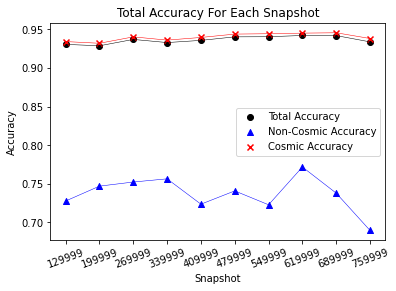

In [11]:
plt.plot(snapshot_nums, total_acc, color="black", linewidth=.5)
plt.scatter(snapshot_nums, total_acc, label="Total Accuracy", color='black')

plt.plot(snapshot_nums, non_cosmic_acc, color="blue", linewidth=.5)
plt.scatter(snapshot_nums, non_cosmic_acc, label="Non-Cosmic Accuracy", color='blue', marker="^")

plt.plot(snapshot_nums, cosmic_acc, color="red", linewidth=.5)
plt.scatter(snapshot_nums, cosmic_acc, label="Cosmic Accuracy", color='red', marker='x')

plt.title("Total Accuracy For Each Snapshot")
plt.ylabel("Accuracy")
plt.xlabel("Snapshot")
plt.xticks(snapshot_nums, rotation=20)
plt.legend()
plt.show();


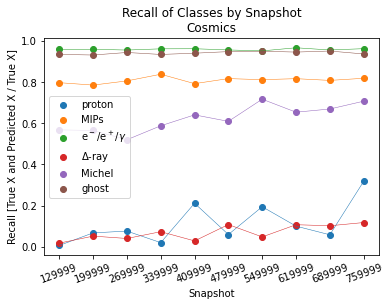

In [12]:
# Plot all recalls for cosmics
plt.plot(snapshot_nums, c_proton_rec, linewidth=0.5)
plt.scatter(snapshot_nums, c_proton_rec, label=labels[0])
plt.plot(snapshot_nums, c_MIP_rec, linewidth=0.5)
plt.scatter(snapshot_nums, c_MIP_rec, label=labels[1])
plt.plot(snapshot_nums, c_e_rec, linewidth=0.5)
plt.scatter(snapshot_nums, c_e_rec, label=labels[2])
plt.plot(snapshot_nums, c_delta_rec, linewidth=0.5)
plt.scatter(snapshot_nums, c_delta_rec, label=labels[3])
plt.plot(snapshot_nums, c_michel_rec, linewidth=0.5)
plt.scatter(snapshot_nums, c_michel_rec, label=labels[4])
plt.plot(snapshot_nums, c_ghost_rec, linewidth=0.5)
plt.scatter(snapshot_nums, c_ghost_rec, label=labels[5])

# Title etc.
plt.title("Recall of Classes by Snapshot\nCosmics")
plt.ylabel("Recall [True X and Predicted X / True X]")
plt.xlabel("Snapshot")
plt.xticks(snapshot_nums, rotation=20)
plt.legend(loc='center left')
plt.show();

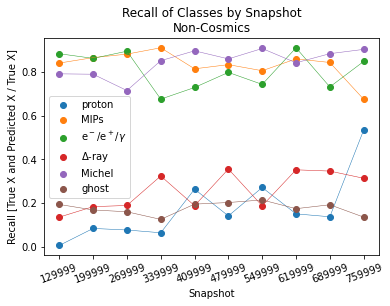

In [13]:
# Plot all recalls for non-cosmics
plt.plot(snapshot_nums, nc_proton_rec, linewidth=0.5)
plt.scatter(snapshot_nums, nc_proton_rec, label=labels[0])
plt.plot(snapshot_nums, nc_MIP_rec, linewidth=0.5)
plt.scatter(snapshot_nums, nc_MIP_rec, label=labels[1])
plt.plot(snapshot_nums, nc_e_rec, linewidth=0.5)
plt.scatter(snapshot_nums, nc_e_rec, label=labels[2])
plt.plot(snapshot_nums, nc_delta_rec, linewidth=0.5)
plt.scatter(snapshot_nums, nc_delta_rec, label=labels[3])
plt.plot(snapshot_nums, nc_michel_rec, linewidth=0.5)
plt.scatter(snapshot_nums, nc_michel_rec, label=labels[4])
plt.plot(snapshot_nums, nc_ghost_rec, linewidth=0.5)
plt.scatter(snapshot_nums, nc_ghost_rec, label=labels[5])

# Title etc.
plt.title("Recall of Classes by Snapshot\nNon-Cosmics")
plt.ylabel("Recall [True X and Predicted X / True X]")
plt.xlabel("Snapshot")
plt.xticks(snapshot_nums, rotation=20)
plt.legend(loc='center left')
plt.show();

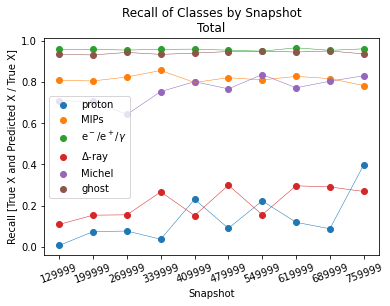

In [14]:
# Plot all recalls for total
plt.plot(snapshot_nums, t_proton_rec, linewidth=0.5)
plt.scatter(snapshot_nums, t_proton_rec, label=labels[0])
plt.plot(snapshot_nums, t_MIP_rec, linewidth=0.5)
plt.scatter(snapshot_nums, t_MIP_rec, label=labels[1])
plt.plot(snapshot_nums, t_e_rec, linewidth=0.5)
plt.scatter(snapshot_nums, t_e_rec, label=labels[2])
plt.plot(snapshot_nums, t_delta_rec, linewidth=0.5)
plt.scatter(snapshot_nums, t_delta_rec, label=labels[3])
plt.plot(snapshot_nums, t_michel_rec, linewidth=0.5)
plt.scatter(snapshot_nums, t_michel_rec, label=labels[4])
plt.plot(snapshot_nums, t_ghost_rec, linewidth=0.5)
plt.scatter(snapshot_nums, t_ghost_rec, label=labels[5])

# Title etc.
plt.title("Recall of Classes by Snapshot\nTotal")
plt.ylabel("Recall [True X and Predicted X / True X]")
plt.xlabel("Snapshot")
plt.xticks(snapshot_nums, rotation=20)
plt.legend(loc='center left')
plt.show();